In [33]:
#data wrangling
import pandas as pd
import datetime as dt
from datetime import date
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
# KPMG Dataset - Transactions sheet
transaction = pd.read_excel("KPMG.xlsx", sheet_name ="Transactions")
print(transaction.head())

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date  
0       71.49          53.62        

In [35]:
# KPMG Dataset - Demographic sheet (Categorical Data)
demographic = pd.read_excel("KPMG.xlsx", sheet_name ="CustomerDemographic")
print(demographic.head())

   customer_id      first_name  last_name  gender  \
0            1         Laraine  Medendorp       F   
1            2             Eli    Bockman    Male   
2            3           Arlin     Dearle    Male   
3            4          Talbot        NaN    Male   
4            5  Sheila-kathryn     Calton  Female   

   past_3_years_bike_related_purchases        DOB               job_title  \
0                                   93 1953-10-12     Executive Secretary   
1                                   81 1980-12-16  Administrative Officer   
2                                   61 1954-01-20      Recruiting Manager   
3                                   33 1961-10-03                     NaN   
4                                   56 1977-05-13           Senior Editor   

  job_industry_category     wealth_segment deceased_indicator  \
0                Health      Mass Customer                  N   
1    Financial Services      Mass Customer                  N   
2              Property

/var/folders/3n/yyrhymr543q0nk46r2nrtdpw0000gn/T/ipykernel_25364/1123014025.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  demographic = pd.read_excel("KPMG.xlsx", sheet_name ="CustomerDemographic")


# 1. Data Correction

In [36]:
#Count missing data
df.isna().sum()


transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [37]:
# Clean data
transaction_dropna = transaction.dropna(how='all')
demographic_dropna = demographic.dropna(how='all')

In [38]:
# Print unique values of 'gender'
print(demographic_dropna['gender'].unique())


['F' 'Male' 'Female' 'U' 'Femal' 'M']


In [39]:
# Correct 'gender' column with 3 unique values: Female, Male & Unisex
demographic_c = demographic_dropna.replace(['F', 'Femal', 'U', 'M'],['Female', 'Female', 'Unisex', 'Male'])
print(demographic_c['gender'].unique())


['Female' 'Male' 'Unisex']


In [40]:
# Classify customer groups by age: "Young" (below 35), "Middle" (35-55), "Older" (above 55) 
now = pd.to_datetime('now')
demographic_c['age'] = (now - demographic_c['DOB']).astype('<m8[Y]')

age_bins = [0,35,55,200]
age_labels = ['Young', 'Middle', 'Older']
demographic_c['age_group'] = pd.cut(demographic_c['age'], bins=age_bins, labels=age_labels, right=False)

/Users/jeaniedo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


# 2. Data Completeness

In [41]:
#Print all transactions which missed values: first_name or last_name of customers:
transaction_c = transaction.dropna(how='all')


In [42]:
transaction_demographic = transaction_c.merge(demographic_c, on ='customer_id', how = 'left')
transaction_sorted = transaction_demographic.sort_values('customer_id')
missing_last_or_first = transaction_demographic.loc[transaction_demographic['first_name'].isnull() | transaction_demographic['last_name'].isnull() , ['customer_id']]

missing_info_transactions = transaction_c[transaction_c['customer_id'].isin(missing_last_or_first['customer_id'])]
print(missing_info_transactions)


       transaction_id  product_id  customer_id transaction_date  online_order  \
45                 46          66         3053       2017-06-20           0.0   
46                 47          35          475       2017-05-07           1.0   
51                 52          96          857       2017-11-27           0.0   
75                 76          22          927       2017-03-10           0.0   
96                 97          80          211       2017-05-31           1.0   
...               ...         ...          ...              ...           ...   
19905           19906          91         2073       2017-02-21           0.0   
19944           19945          31          657       2017-03-01           0.0   
19969           19970           5         3401       2017-10-18           1.0   
19983           19984          80          275       2017-07-02           0.0   
19985           19986          36         2918       2017-11-09           1.0   

      order_status         

# 3. Data Aggregation

In [43]:
# Number of unique customers
transaction_c['customer_id'].nunique()

3494

In [44]:
# Calculate number of customers by month

transaction_c['year_month'] = transaction_c['transaction_date'].dt.strftime("%m")
transaction_c.groupby('year_month')['customer_id'].nunique()

year_month
01    1354
02    1286
03    1317
04    1310
05    1310
06    1266
07    1354
08    1372
09    1263
10    1414
11    1319
12    1322
Name: customer_id, dtype: int64

In [45]:
# Calculate gross_margin by months

transaction_c['gross_margin'] = transaction_c['list_price'] - transaction_c['standard_cost']
transaction_c.groupby('year_month')['gross_margin'].sum()

year_month
01    929487.739988
02    870819.060000
03    879243.400000
04    904691.310000
05    913742.610000
06    859571.550000
07    938619.290000
08    970452.520000
09    862290.490000
10    984973.464984
11    924938.460000
12    891454.070000
Name: gross_margin, dtype: float64

In [46]:
# Calculate number of orders and revenue group by online_order & order_status 

transaction_c.groupby(['online_order', 'order_status'])['transaction_id'].count()

online_order  order_status
0.0           Approved        9735
              Cancelled         76
1.0           Approved        9732
              Cancelled         97
Name: transaction_id, dtype: int64

In [47]:
transaction_c.groupby(['online_order', 'order_status'])['list_price'].sum()

online_order  order_status
0.0           Approved        10776568.41
              Cancelled          87043.72
1.0           Approved        10771244.16
              Cancelled         108924.20
Name: list_price, dtype: float64

4. Data Visualization

In [48]:
# Sử dụng seaborn và vẽ ra 5 chart khác nhau (column, line, box,...) với đầy đủ tên chart, tên các trục và chú thích.

#Gather data
data = transaction_c.merge(dg1, on ='customer_id')
print(data[['age', 'list_price', 'year_month', 'gross_margin','age_group']])

        age  list_price year_month  gross_margin age_group
0      67.0       71.49         02         17.87     Older
1      67.0     1403.50         10        448.68     Older
2      67.0      478.16         04        179.44     Older
3      43.0     2091.47         05       1702.55    Middle
4      43.0     1129.13         10        451.65    Middle
...     ...         ...        ...           ...       ...
19992  25.0     1636.90         02       1592.19     Young
19993  29.0     1024.66         12        409.86     Young
19994  29.0     1073.07         06        139.23     Young
19995  55.0      792.90         12        198.22     Older
19996  55.0      235.63         12        110.56     Older

[19997 rows x 5 columns]


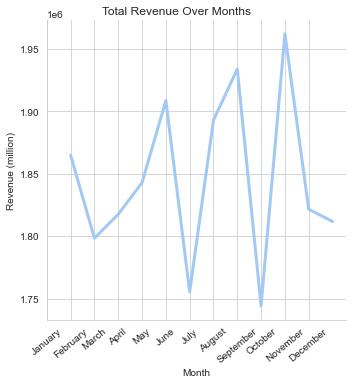

In [58]:
#01 Line chart 1: Total revenue over months

data_line = data.groupby(['year_month'])['list_price'].sum().reset_index()
data_line['year_month'] = data_line['year_month'].astype(int)

sns.set_style('whitegrid')
line1 = sns.relplot(x = 'year_month', y = 'list_price', 
                    data = data_line, kind = 'line', linewidth=3)
line1.fig.suptitle("Total Revenue Over Months")
line1.set(xlabel ="Month", ylabel="Revenue (million)")

plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=40);

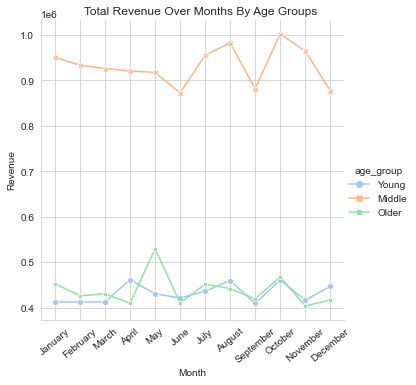

In [50]:
#02 Line chart 2: Total revenue over months by age_group
data_line2 = data.groupby(['year_month','age_group'])['list_price'].sum().reset_index()

line2 = sns.relplot(x = 'year_month', y = 'list_price', 
            data = data_line2, 
            kind = 'line', 
            style = 'age_group', 
            hue = 'age_group',
            markers = True,
            dashes = False)
line2.fig.suptitle("Total Revenue Over Months By Age Groups")
line2.set(xlabel ="Month", ylabel="Revenue")
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=40);

Insight of Graph 01 & 02: July & October have lowest revenue but overall the total revenue is pretty stable. 
Middle age group contributes the highest proportion of total revenue. 

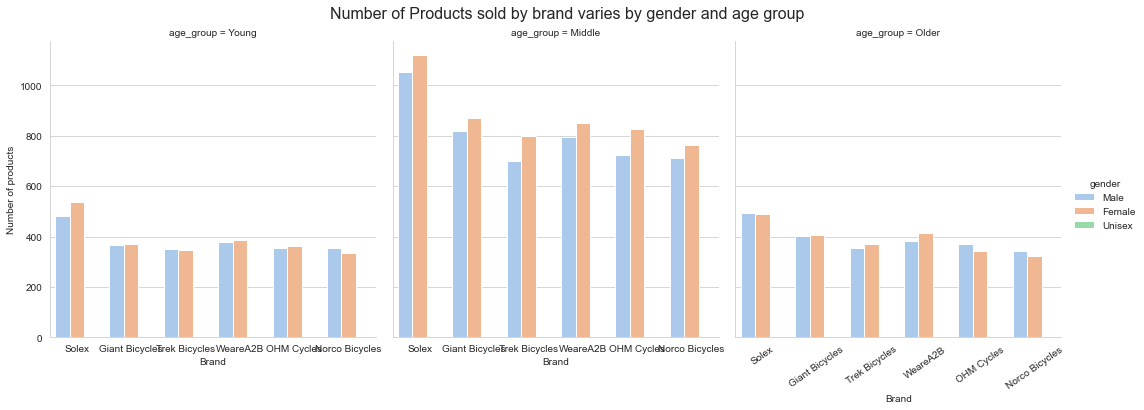

In [52]:
#03 Bar chart 1: Count number of product sold by brand varies by gender
sns.set_style('whitegrid')
sns.set_palette('pastel')

bar1 = sns.catplot(x='brand', data=data, kind='count', hue='gender', col='age_group')
bar1.fig.suptitle('Number of Products sold by brand varies by gender and age group', y =1.03, fontsize =16)
bar1.set(xlabel ='Brand', ylabel='Number of products')
plt.xticks(rotation=35);

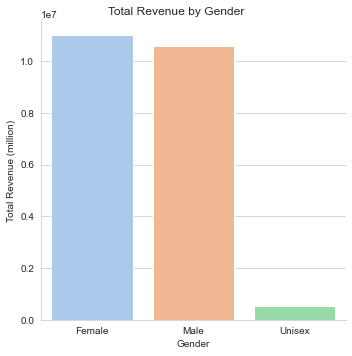

In [53]:
#04 Bar chart 2: Total Revenue by gender
data_bar = data.groupby(['gender'])['list_price'].sum().reset_index()
bar2 = sns.catplot(x='gender', y='list_price', data=data_bar, kind='bar')
bar2.fig.suptitle('Total Revenue by Gender')
bar2.set(xlabel ='Gender', ylabel='Total Revenue (million)')

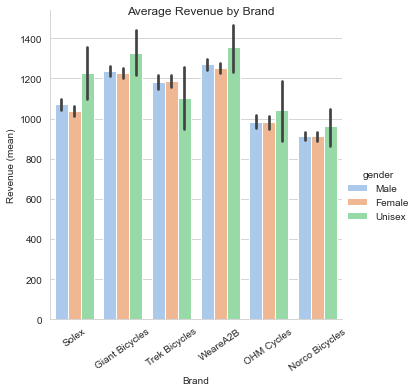

In [54]:
#05 Bar chart 3: Average revenue of each brand 
bar3 = sns.catplot(x='brand', y='list_price', data=data, kind='bar', hue='gender')
bar3.fig.suptitle('Average Revenue by Brand')
bar3.set(xlabel ='Brand', ylabel='Revenue (mean)')
plt.xticks(rotation=35);

Insight of Chart 04 & 05: Although gender 'Unisex' generates the lowest revenue but the average payment per transaction is the highest.
Company should promote their products with more focused on gender 'Unisex'.